In [2]:
library(dplyr)
library(ggplot2)
library(tidyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
get_cumulative_length=function(chrom_lengths){
    n_chrom=length(chrom_lengths)
    cumulative_length=c(0,cumsum(x = unname(chrom_lengths))[1:(n_chrom-1)])
    names(cumulative_length)=names(chrom_lengths)
    return(cumulative_length)
}

get_total_length=function(chrom_lengths){
    sum(chrom_lengths)
}

get_x_breaks=function(chrom_lengths){
    cumulative_length=get_cumulative_length(chrom_lengths)
    x_breaks=cumulative_length+round(chrom_lengths/2)
    return(x_breaks)
}

add_cumulative_pos=function(data,chrombuild){
    if (!all(c('chrom','pos','y')%in%colnames(data))){
        stop('data must have chrom, pos and y columns')
    }
    chrom_lengths=chrombuild
    cumulative_length=get_cumulative_length(chrom_lengths)

    calc_cumulative_pos=function(chrom,pos,cumulative_length){
        stopifnot(length(unique(chrom))==1)
        #* 注意染色体排序的问题
        stopifnot(chrom%in%names(cumulative_length))
        pos+cumulative_length[chrom]
    }
    for (i in names(chrom_lengths)){
        data[data$chrom==i,'cumulative_pos']=data[data$chrom==i,'pos']+cumulative_length[i]
        #* 添加图层，防止相邻染色体重叠的问题
        data[data$chrom==i,'Zinde']=cumulative_length[i]
    }
    return(data)
}

add_color=function(data,chrombuild,color1='black',color2='grey'){
    if ('color'%in%colnames(data)){
        user_color=data$color
    } else {
        user_color=rep(NA,nrow(data))
    }
    #* 间隔不同的染色体，上颜色
    selectChrom=names(chrombuild[seq(1,length(chrombuild),2)])
    data$color=ifelse(data$chrom%in%selectChrom,color1,color2)
    data$color=ifelse(is.na(user_color),data$color,user_color)
    return(data)
}

add_shape = function(data,shape=16){
    if ('shape'%in% colnames(data)){
        user_shape = data$shape
    } else {
        user_shape = rep(NA, nrow(data))
    }
    
    data$shape = shape
    data$shape = ifelse(is.na(user_shape),data$shape,user_shape)
    return(data)
}


add_fill = function(data){
    if ('fill'%in%colnames(data)){
        NULL
    } else {
        data$fill = data$color
    } 
    return(data)
}

#' Make a Manhattan plot
#' @param gwas A GWAS study. Must have chrom, pos, and y columns
#' @param build Genomic build. Currently supports hg18, hg19, and hg38
#' @param color1 Color for odd-numbered chromosomes
#' @param color2 Color for even-numbered chromosomes
#' @example
#' data(cad_gwas)
#' cad_gwas$y=-log10(cad_gwas$pval)
#' manhattan(cad_gwas,build='hg18')
#' @return a ggplot object that makes a Manhattan plot
#' @details
#' \code{manhattan} is a wrapper around \code{ggplot}. It uses a few tricks to transform a genomic axis to a scatterplot axis. For instance, chr2:1 would be the length of chromosome 1 plus 1, chr3:1 would be chromosome 1 plus chromosome 2 plus 1, so on and so forth. It is important to specify the genomic build (e.g. hg19) so that `manhattan` can make the correct transformation. It positions the chromosome labels on the x-axis according to these transformations.
manhattan=function(gwas,chromBuild,color1='black',color2='grey'){
    data=gwas
    data=add_cumulative_pos(data,chromBuild)
    data=add_color(data,chromBuild,color1 = color1,color2 = color2)
    data=add_shape(data,shape=16)
    data=add_fill(data)
    xmax=get_total_length(chromBuild)
    x_breaks=get_x_breaks(chromBuild)
    
    color_map=unique(data$color)
    names(color_map)=unique(data$color)
    #* 根据SNP ID 去除
    threshold=-log10(1/dim(unique(data[,c(1,2)]))[1])
    ggplot2::ggplot(data,aes(x=cumulative_pos,y=y,color=color,fill=fill,shape=shape))+
        geom_point(
        )+
        theme_classic()+
        scale_x_continuous(limits=c(0,xmax),expand=c(0.01,0),breaks=x_breaks,
                           labels=names(x_breaks),name='Chromosome')+
        scale_y_continuous(expand=c(0,0),
        name=expression('-log10(P-value)'),
        limits = c(0,max(data$y)+1))+
        scale_color_manual(values=color_map,guide='none')+
        scale_fill_manual(values = color_map, guide = 'none')+
        scale_shape_identity()+
        geom_hline(
            yintercept = threshold,
            color='red'
        )+theme(
            axis.title.x=element_blank(),
            axis.text.x=element_text(angle = 20,size=12,vjust = 0.5)
        )
}

In [61]:
#* 获取所有GWAS的结果
GWASData=read.table("../All_GWAS_result.txt",header=T)

In [5]:
ChromBuild <- c(
    Chr1 = 119507322, Chr2 = 108450422, Chr3 = 113408019, Chr4 = 89221110,
    Chr5 = 113074602, Chr6 = 128222162, Chr7 = 98898484, Chr8 = 126387757, Chr9 = 87595469,
    Chr10 = 118171768, Chr11 = 124349965, Chr12 = 109156372, Chr13 = 112588652, Chr14 = 65918158,
    Chr15 = 73101677, Chr16 = 54886762, Chr17 = 59484712, Chr18 = 67198243, Chr19 = 66923722,
    Chr20 = 60694631, Chr21 = 71738969, Chr22 = 55964494, Chr23 = 68897365, Chr24 = 73407149,
    Chr25 = 64840153, Chr26 = 65092848
)

In [107]:
#-----------------------------------------------------------
#TODO 对每个性状进行单独分析
#! 汇集所有单年，单点以及blup的数据集
#-----------------------------------------------------------
SNPCount=dim(GWASData)[1]
#* 筛选某个性状的所有GWAS_test 
filterGWAS=colnames(GWASData)[startsWith(colnames(GWASData),'SI')]

filterGWASResult=GWASData %>% select(all_of(c("Chromosome","Position",filterGWAS))) %>%  pivot_longer(
    cols = starts_with('SI'),
    values_to = 'pvalue',
    names_to = 'GWAS'
)
#* 计算pvalues
filterGWASResult=filterGWASResult %>% mutate(
        y=-log10(pvalue),
        Chromosome=paste0("Chr",Chromosome),
        SNPId=paste(Chromosome,Position,sep="_"),
        #* 显著性的阈值稍微降一点！
        sig=ifelse(y>=-log10(1/SNPCount),1,0)
    )
colnames(filterGWASResult)=c('chrom','pos','GWAS','pvalue','y','SNPId','sig')
#TODO 筛选pvalue小于阈值的SNPs
filterGWASResult=arrange(filterGWASResult,chrom,pos,y)
#* 13个GWAS test才是对的
length(unique(filterGWASResult$GWAS))

[1] 12

In [108]:
#* 过滤得到显著性的SNPs list
sigSNPId <- unique(filterGWASResult %>% filter(sig == 1) %>% select(SNPId))
#! 根据SNP ID获得同一个lead SNP在不同GWAS test中最显著的pvalues
leadSNPPval=filterGWASResult %>%
    filter(
        SNPId %in% sigSNPId$SNPId
    ) %>%
    group_by(SNPId) %>%
    summarise(
        P=min(pvalue)
    )
#* 每个significant SNP在不同GWAS test中是否为显著，以及所有
upsetGWASData=filterGWASResult %>% filter(SNPId %in% sigSNPId$SNPId ) %>% pivot_wider(
    id_cols = SNPId,
    names_from = GWAS,
    values_from = sig
)
#* 合并后的
MergeData <- merge(upsetGWASData, leadSNPPval, on = "SNPId")
write.table(
    MergeData,
    "SI_sigSNP.txt",
    col.names = T,
    row.names = F, sep = "\t",
    quote = F
)


In [110]:
#* 读取QTL lead SNPs
leadSNPList=read.table("./SI_QTL_leadSNP.txt",header=T,sep="\t")
head(leadSNPList)

,SNPId,SI.XJ.15,SI.YC.14,SI.AY.15,SI.YC.15,SI.CZ.15,SI.DH.15,SI.JZ.15,SI.AY.14,SI,SI.XJ.14,SI.DH.14,SI.JZ.14,P
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,Chr10_91984902,0,0,0,0,0,0,0,0,0,0,0,1,8.629111e-06
2,Chr12_99541022,0,0,1,0,0,0,0,0,0,0,0,0,1.923625e-05
3,Chr15_2790605,0,0,0,0,0,0,0,0,0,0,0,1,5.457107e-06
4,Chr22_19545230,0,0,0,0,0,0,0,0,0,1,0,0,1.319014e-05
5,Chr22_51357680,0,0,0,0,0,1,0,0,0,0,0,0,1.387279e-05
6,Chr23_51988804,0,0,0,1,0,0,0,0,0,0,0,0,1.292629e-05


In [111]:
#-----------------------------------------
# 修改lead SNP的颜色和labels
# ? 存在多个相同名称的SNP ID
# ! 根据SNP ID 和对应的pvalue修改lable和color
#-----------------------------------------
# filterGWASResult[(filterGWASResult$SNPId %in% leadSNPList$SNPId)&&(filterGWASResult$pvalue % leadSNPList$SNPId), "color"] <- "red"
#* 修改label和color
leadSNPlistLabel <- leadSNPList %>%
    pivot_longer(
        cols = starts_with("SI"),
        names_to = "GWAS_test",
        values_to = "sig"
    ) %>%
    filter(sig == 1) %>%
    count(SNPId) %>%
    mutate(label = gsub("Chr","",paste(SNPId, n, sep = "_")))
#* QTL labels
leadSNPlistLabel <- as.data.frame(leadSNPlistLabel)
#* mergeData
mergeData <- merge(leadSNPlistLabel, leadSNPList %>% select(c("SNPId", "P")), on = "SNPId")
#* 根据SNP Id 修改对应的label
for (index in 1:nrow(mergeData)) {
    filterGWASResult[
        (filterGWASResult$SNPId == mergeData[index, 1]) & (
            round(filterGWASResult$y, 2) == round(-log10(mergeData[index, 4]), 2)
        ), "label"
    ] <- mergeData[index, 3]
    #* 修改颜色
    filterGWASResult[
        (filterGWASResult$SNPId == mergeData[index, 1]) & (
            round(filterGWASResult$y, 2) == round(-log10(mergeData[index, 4]), 2)
        ), "color"
    ] <- "red"
    #* 性状
    filterGWASResult[
        (filterGWASResult$SNPId == mergeData[index, 1]) & (
            round(filterGWASResult$y, 2) == round(-log10(mergeData[index, 4]), 2)
        ), "shape"
    ] <- 23
}
filterGWASResult$shape=as.integer(filterGWASResult$shape)

png 
  2

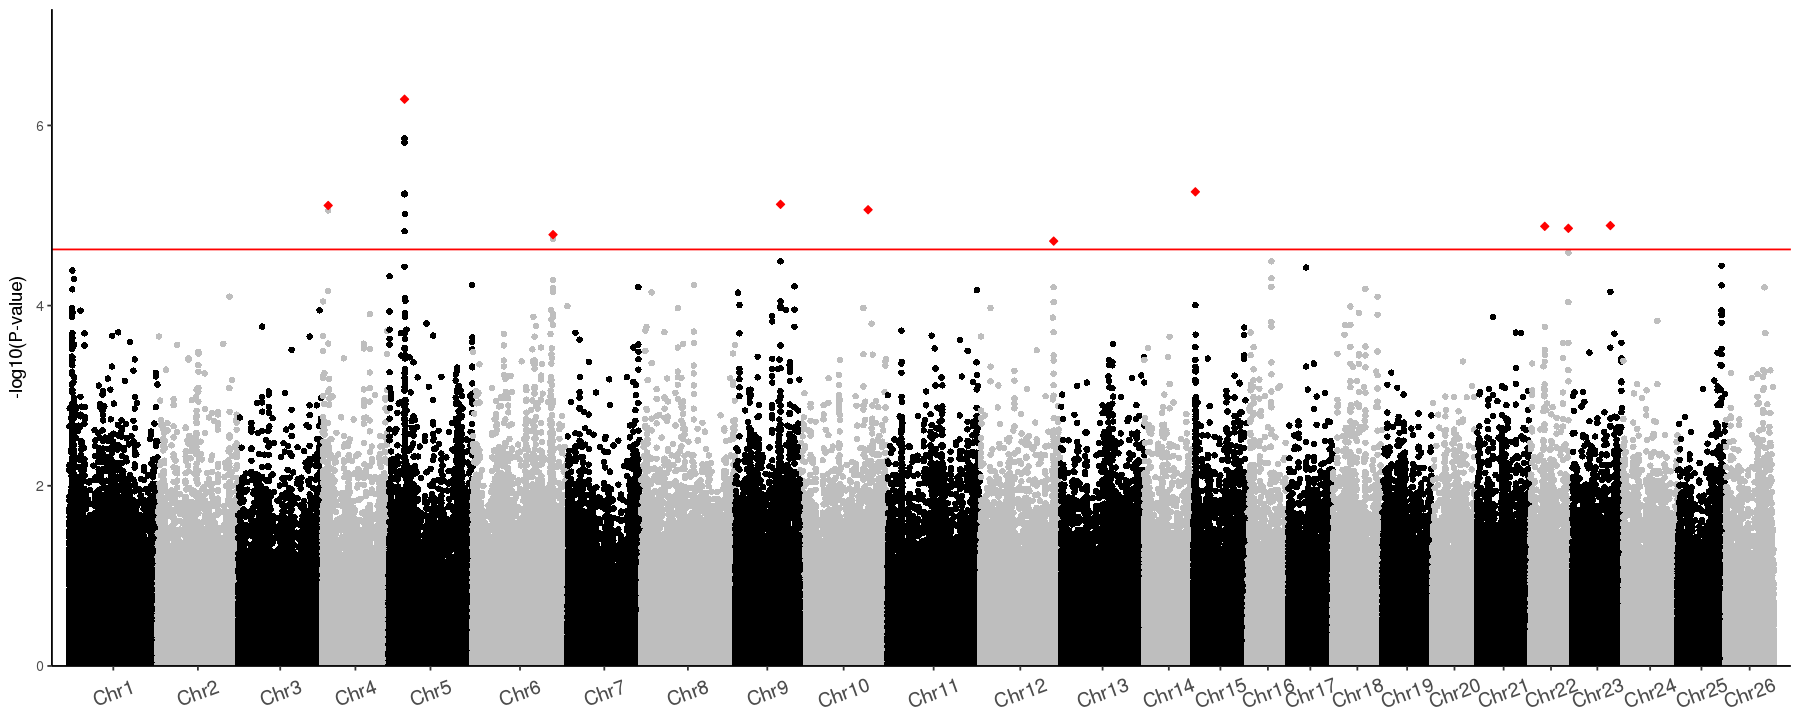

In [112]:
options(repr.plot.width = 15, repr.plot.height = 6)
p=manhattan(
    filterGWASResult, ChromBuild
)
png("SI_cohort_manhattan.png",width = 15000,height = 6000,res=600)
print(p)
dev.off()
p

In [2]:
library(UpSetR)

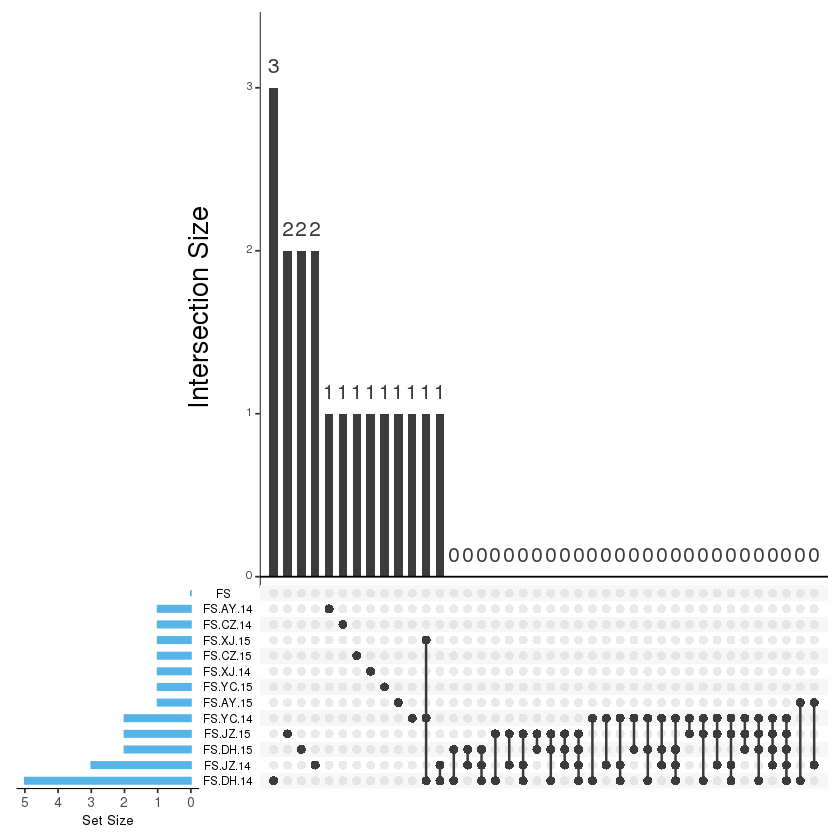

In [4]:
#* 读取QTL lead SNPs
#* 绘制韦恩图
leadSNPList=read.table("./FS_QTL_leadSNP.txt",header=T,sep="\t")
GWASTestList=colnames(leadSNPList)[startsWith(colnames(leadSNPList),'FS')]
p=upset(leadSNPList,
    sets =GWASTestList, sets.bar.color = "#56B4E9",
    order.by = "freq", empty.intersections = "on",
    text.scale = c(2, 1, 1, 1.2, 1, 2) # 设置各种text文字大小
)
png("FS_cohort_upset.png",width = 6000,height = 3000,res=600)
print(p)
dev.off()
p

In [123]:
#TODO 对于每个合并后的QTL区间统计其在不同性状的显著性Pvalue
AllQTL_leadSNP=read.table("./All_trait_leadSNP.txt",header=F,sep="\t")
AllQTL_list=read.table("./All_trait_QTL_merge.txt")
traitList=c(
    'BW','FD','FE','FL','FM','FS',
    'FU','FWPB','LI','LP','MAT','SCI','SI'
)

In [132]:
All_trait_QTLList <- data.frame(
    Chrom = character(),
    start = integer(),
    end = integer(),
    pval = double(),
    trait = character(),
    stringsAsFactors = F
)
for (index in 1:nrow(AllQTL_list)) {
    QTLChrom <- AllQTL_list[index, 1]
    QTLStart <- AllQTL_list[index, 2]
    QTLEnd <- AllQTL_list[index, 3]
    #* 存在显著性的性状
    filterData <- AllQTL_leadSNP  %>% filter(
        (V1==QTLChrom)&(
            V2 >= QTLStart
        )&(
            V3 <= QTLEnd
        )
    )
    #* 对所有的lead SNP和性状取交集
    for (trait in traitList) {
        pval <- filterData[filterData$V5 == trait, 4]
        if (length(pval)==1){
            All_trait_QTLList[nrow(All_trait_QTLList) + 1, ] <- c(
                as.character(QTLChrom),
                as.integer(QTLStart), 
                as.integer(QTLEnd),
                 as.double(pval), 
                 trait
            )

        } else if (length(pval)>1) {
        #! 同一个区间的多个QTL被合并
         All_trait_QTLList[nrow(All_trait_QTLList) + 1, ] <- c(
                as.character(QTLChrom),
                as.integer(QTLStart), 
                as.integer(QTLEnd),
                 pval[-1], 
                 trait
            )
        }else {
            All_trait_QTLList[nrow(All_trait_QTLList) + 1, ] <- c(
                as.character(QTLChrom),
                as.integer(QTLStart), 
                as.integer(QTLEnd),
                 1, 
                 as.character(trait)
            )
        }
    }
}
All_trait_QTLList$Chrom=factor(All_trait_QTLList$Chrom)
All_trait_QTLList$start=as.integer(All_trait_QTLList$start)
All_trait_QTLList$end=as.integer(All_trait_QTLList$end)
All_trait_QTLList$pval=as.double(All_trait_QTLList$pval)
All_trait_QTLList$trait=as.factor(All_trait_QTLList$trait)

In [133]:
#* 以热图的形式进行绘制
All_trait_QTLList <- All_trait_QTLList %>%
    mutate(
        QTLId = paste(Chrom, start, end, sep = "_"),
        pvalT = -log10(pval)
    ) %>%
    pivot_wider(
        id_cols = "QTLId",
        names_from = "trait",
        values_from = "pvalT"
    )
# plotData=All_trait_QTLList[,2:14]
All_trait_QTLList=All_trait_QTLList %>% mutate(
    Chrom=gsub('_[0-9].*','',QTLId),
    subGenome=ifelse(as.integer(gsub('Chr','',Chrom))>=13,'Dt','At')
)
plotData=as.data.frame(All_trait_QTLList[,c(2:14,16)])
rownames(plotData)=as.vector(All_trait_QTLList$QTLId)
#* 区分两个亚组
At_plotData=plotData %>% filter(subGenome=='At') %>% select(!c('subGenome'))
Dt_plotData=plotData %>% filter(subGenome=='Dt') %>% select(!c('subGenome'))

In [175]:
dim(At_plotData)
dim(Dt_plotData)

[1] 75 13

[1] 74 13

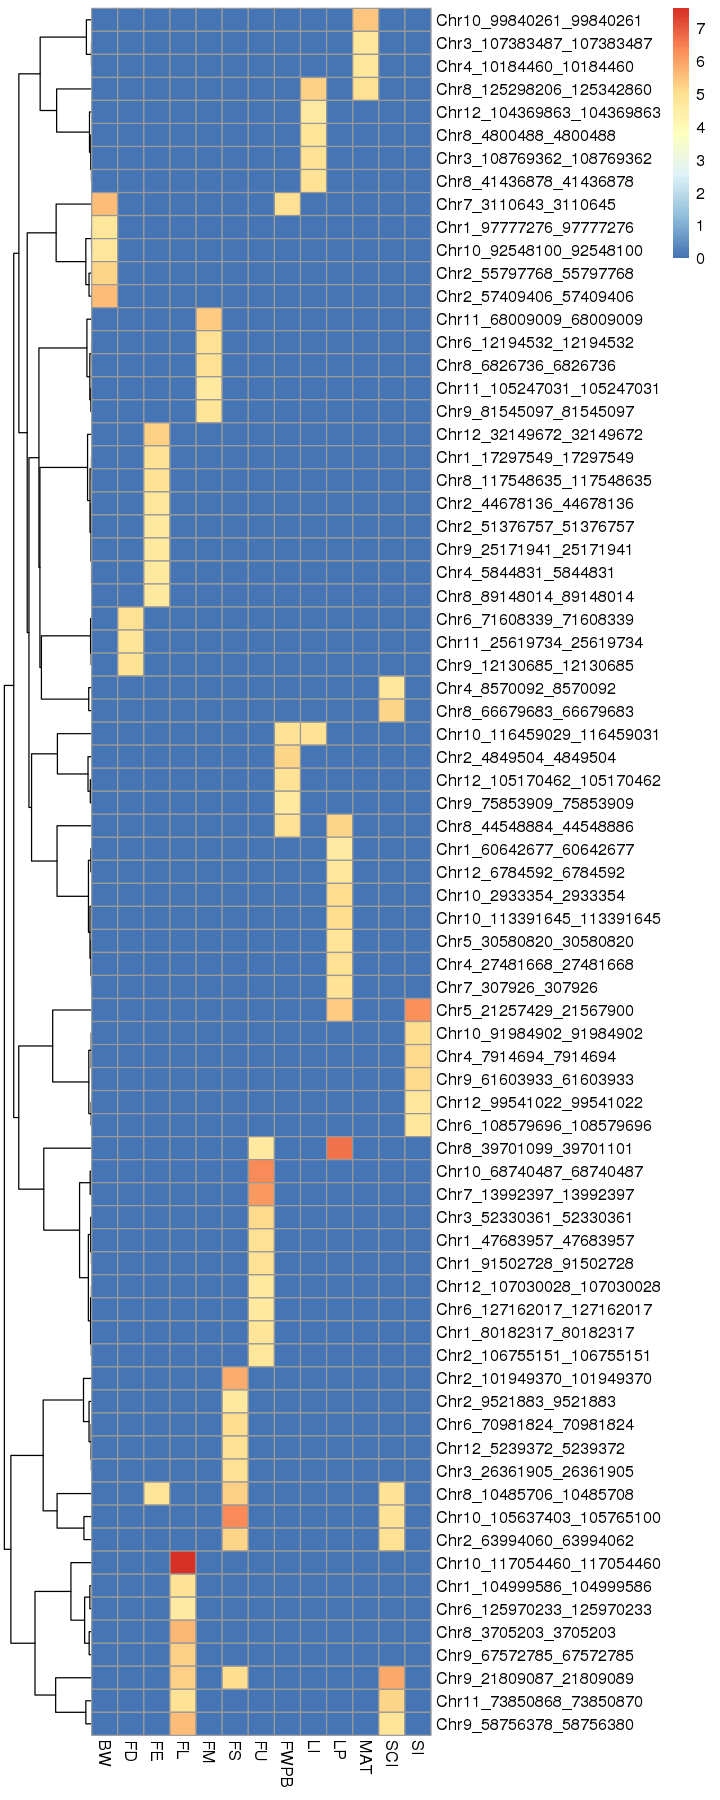

In [173]:
options(repr.plot.width = 6, repr.plot.height = 15)
library(pheatmap)
pheatmap(
    At_plotData,
    cluster_rows = T,
    cluster_cols = F
)